<a href="https://colab.research.google.com/github/KianShokraneh/Background-Importance-Analysis-Using-Gradient-SHAP/blob/main/Background_Importance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Required Dependecies**

In [ ]:
!pip install torch torchvision captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

##**Mount Google Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Import & Setup**

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import random
from captum.attr import GradientShap


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('drive/MyDrive/resnet18_cifar10.pth'))
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified


##**Define Function to Calculate Attributions**

In [ ]:
def gradshap(img_path):
  img = Image.open(img_path).convert('RGB')
  input_tensor = preprocess(img)
  input_batch = input_tensor.unsqueeze(0).to(device)

  output = model(input_batch)
  predicted_class = output.argmax(dim=1).item()

  class_names = cifar10.classes
  print(f'{class_names[predicted_class]} ({predicted_class})')


  gs = GradientShap(model)
  baseline_dist = torch.cat([input_batch * 0, input_batch * 1])
  attributions = gs.attribute(input_batch, baselines=baseline_dist, target=predicted_class, n_samples=50)

  attributions = attributions.squeeze().cpu().detach().numpy()
  attributions = np.transpose(attributions, (1, 2, 0))
  attributions = np.sum(np.abs(attributions), axis=2)
  attributions = attributions / np.max(attributions)

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].imshow(transforms.ToPILImage()(input_tensor))
  ax[0].axis('off')
  ax[1].imshow(transforms.ToPILImage()(input_tensor))
  ax[1].imshow(attributions, cmap='hot', alpha=0.5)
  ax[1].axis('off')
  plt.show()

#**Visualize results for samples**

airplane (0)


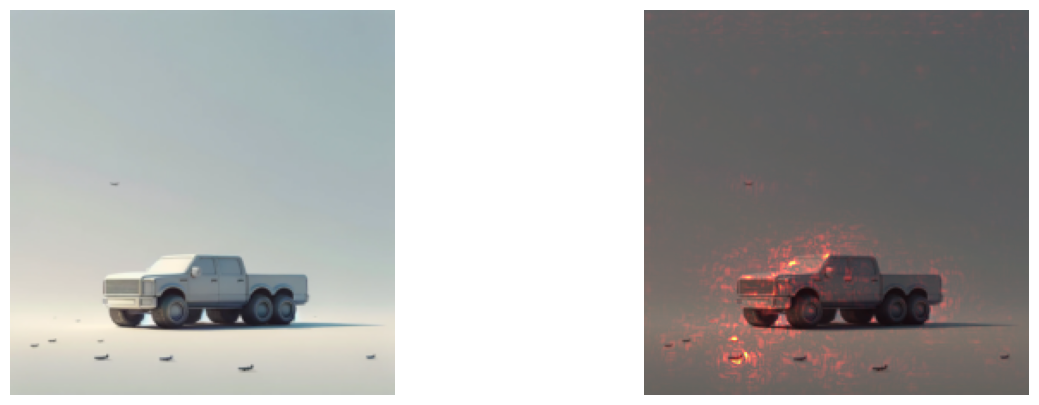

dog (5)


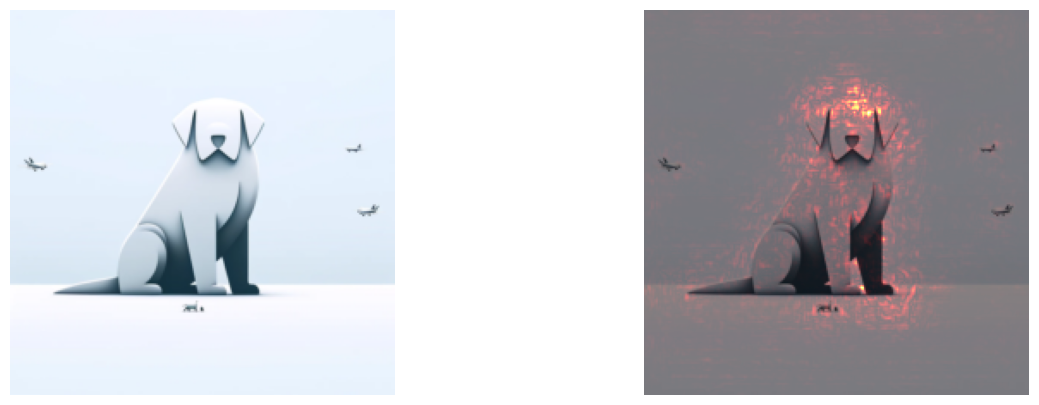

In [ ]:
gradshap('car.webp')
gradshap('dog.webp')